In [18]:
# packages and dependencies import
import pandas as pd
import seaborn as sns # Used for Exploratory Data Analysis
import numpy as np
import matplotlib
from pandas import DataFrame

# matplotlib.use('TkAgg')  # or 'QtAgg' if PyQt is installed {pip install PyQt6}
import matplotlib.pyplot as plt

In [19]:
# Data Import
data = pd.read_csv("/home/tjselevani/PycharmProjects/PythonProject/data/last-3-months-transactions.csv")

# Convert 'created_at' column to datetime if not already
data['created_at'] = pd.to_datetime(data['created_at'])

# Extract time in minutes since start of the day
data.loc[:, 'minutes'] = data['created_at'].dt.hour * 60 + data['created_at'].dt.minute

# Extract time in hours since start of the day
data.loc[:, 'hours'] = data['created_at'].dt.hour

# Extract the week from 'created_at'
data.loc[:, 'week'] = data['created_at'].dt.to_period('W').astype(str)

# Extract the month from 'created_at'
data.loc[:, 'month'] = data['created_at'].dt.to_period('M').astype(str)

In [20]:
def format_minutes_xticks():
    """Returns tick positions and labels for minutes of the day."""
    return range(0, 1441, 60), [f"{h}:00" for h in range(0, 25)]

def format_hours_xticks():
    """Returns tick positions and labels for hours of the day."""
    return range(0, 25, 1), [f"{h}:00" for h in range(0, 25)]

def format_weeks_xticks(week_labels):
    """Returns tick positions and labels for weeks."""
    return range(len(week_labels)), week_labels

def format_months_xticks(month_labels):
    """Returns tick positions and labels for months."""
    return range(len(month_labels)), month_labels

def format_years_xticks(year_labels):
    """Returns tick positions and labels for years."""
    return range(len(year_labels)), year_labels

In [21]:
#data.head()

In [22]:
#data.tail()

In [23]:
#data.shape

In [24]:
#data.columns

In [25]:
#data.describe()

In [26]:
#data.isnull().sum()

In [27]:
#Data Visualization

In [28]:
# Filter data for the specific vehicle
def get_vehicle_data(vehicle_id):
    """Returns all, credit, and debit transaction data for a given vehicle."""
    vehicle_df = data[data['vehicle_booked'] == vehicle_id].copy()
    
    return {
        "all": vehicle_df,
        "credit": vehicle_df[vehicle_df['transaction_type'] == 'CREDIT'].copy(),
        "debit": vehicle_df[vehicle_df['transaction_type'] == 'DEBIT'].copy(),
    }

# Define the vehicles
vehicles = ['SM191', 'SM192', 'SM055', 'SM024']

# Create a dictionary to store data for all vehicles
vehicle_data_dict = {v: get_vehicle_data(v) for v in vehicles}

# Select a specific vehicle dynamically
selected_vehicle = 'SM024'  # Change this to switch vehicles

vehicle_data = vehicle_data_dict[selected_vehicle]['credit']
vehicle_revenue = vehicle_data_dict[selected_vehicle]['debit']
data = vehicle_data_dict[selected_vehicle]['all']

/tmp/ipykernel_289273/2839188378.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='week', y='amount', data=weekly_fares, palette="viridis")


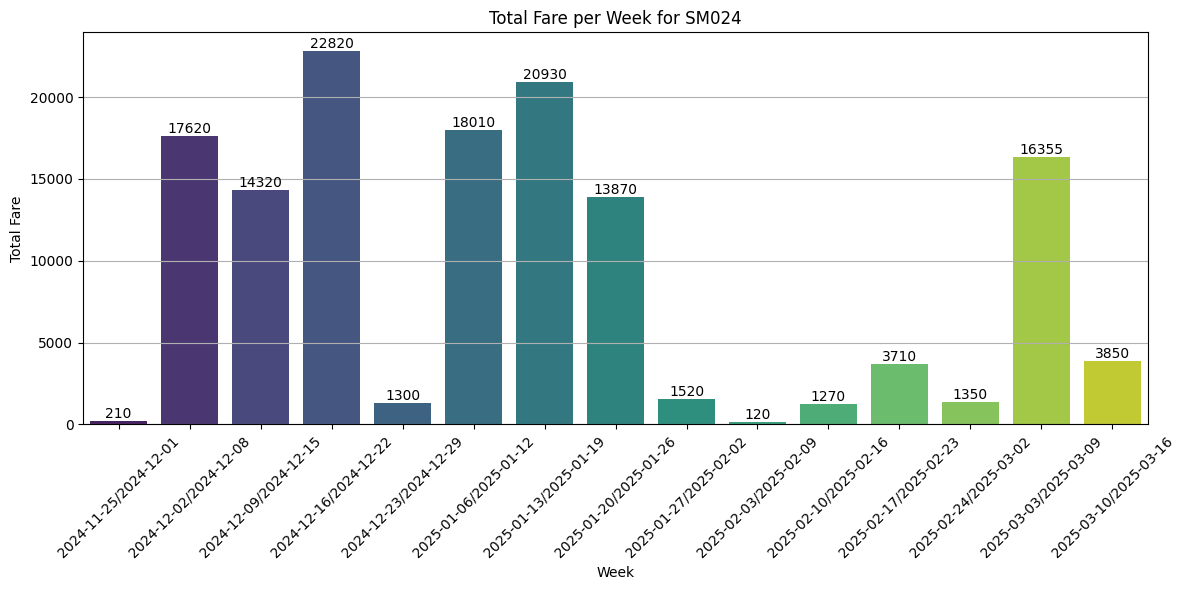

In [29]:
""" {2} """
# Aggregate total fare for each week
weekly_fares = vehicle_data.groupby('week')['amount'].sum().reset_index()

# Plot weekly fare as a bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x='week', y='amount', data=weekly_fares, palette="viridis")

plt.title(f"Total Fare per Week for {selected_vehicle}")

plt.xlabel("Week")
plt.ylabel("Total Fare")

week_labels = sorted(data['week'].unique())  # Ensure weeks are sorted
xticks, labels = format_weeks_xticks(week_labels)
plt.xticks(xticks, labels=labels, rotation=45)
plt.grid(axis='y')

# Add annotations for each bar
for i, amount in enumerate(weekly_fares['amount']):
    plt.text(i, amount, f"{amount}", ha='center', va='bottom')

plt.tight_layout()  # Adjust layout so annotations fit

plt.show()
